In [5]:
import os
import pickle
import datetime

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from datasets import Dataset

import madmom

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ds = Dataset("initslurtest")
audio_fnames = ds.get_audio_paths()
label_fnames = ds.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [genfromtxt(label_fname, delimiter=',') for label_fname in label_fnames]


Dataset created
Found 20 audio files and 0 annotation files.


/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [ ]:
[print("Name of rec: {}\n"
       "Len in seconds: {:.2f}\n"
       "Shape of audio: {}\n"
       "Shape of onset schedule: {}\n"
       "Onsets from {:.2f}s to {:.2f}s\n".format(
                                        os.path.split(fname)[1], 
                                        audio.shape[0]/44100,
                                        audio.shape,
                                        schedule.shape,
                                        schedule.min(),
                                        schedule.max(),
                                        ) 
    ) for fname, audio, schedule in zip(audio_fnames, audios, onset_schedules)
]

In [5]:
onset_vectors = [get_label_vector(sched, len(audio)/SR, HOP, SR)
    for (sched, audio) in zip(onset_schedules, audios)
]
print(onset_vectors[0].shape)

(1697,)


In [27]:
proc = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.OnsetPeakPickingProcessor(smooth=5, pre_avg=5, post_avg=1, pre_max=5, post_max=1)
pp0 = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=0.7)
act_fn = proc(audio_fnames[0])


In [47]:
pred = pp0(act_fn)
print(pred)

[ 0.75  1.11  1.31  1.44  1.61  1.73  1.88  2.05  2.21  2.35  2.63  2.81
  2.92  3.04  3.24  3.4   3.53  3.85  4.03  4.15  4.29  4.46  4.62  4.75
  4.89  5.05  5.18  5.33  5.45  5.67  5.84  5.97  6.13  6.29  6.47  6.58
  6.73  6.89  7.05  7.19  7.32  7.47  7.61  7.76  7.86  8.08  8.21  8.35
  8.46  8.64  8.68  8.84  8.96  9.1   9.26  9.54  9.69  9.85  9.98 10.14
 10.26 10.48 10.62 10.81 10.93 11.07 11.11 11.23 11.36 11.51 11.64 11.78
 11.93 12.03 12.07 12.25 12.38 12.52 12.64 12.84 12.99 13.12 13.23 13.43
 13.6  13.71 13.84 14.   14.14 14.29 14.43 14.58 14.71 14.83 14.98 15.16
 15.71 16.95]


In [49]:
clip_len = np.median(np.diff(pred))/2
np.sum(np.diff(pred)<clip_len)
print(clip_len*44100)


3307.499999999988


In [64]:
framed = np.array(madmom.audio.signal.FramedSignal(audios[0], frame_size=int(clip_len*44100), hop_size=441))

(array([ 3., 17., 23., 29., 21.,  3.,  0.,  0.,  1.,  1.]),
 array([-2311636. , -1341783.9,  -371931.8,   597920.3,  1567772.4,
         2537624.5,  3507476.6,  4477328.7,  5447180.8,  6417032.9,
         7386885. ]),
 <BarContainer object of 10 artists>)

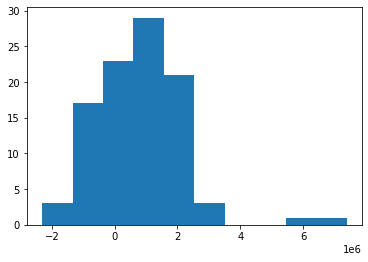

In [90]:
plt.hist(np.sum(framed[(pred*100-4).astype(int)]**2, 1))